##燃費を予測する

In [1]:
mkdir data

In [2]:
cd data

/content/data


## プログラムの実装（まずはインポートなど実装準備）

## ※ matplotlib日本語化のためのライブラリのインストール
### ▶ 以下を実行してください。

In [3]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 5.4 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=28bcbeb11015d18a589073c5d328d757508e792d7f6b5ee6987695aa9a0db4fd
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


##必要なライブラリのインポート

In [4]:
import pandas as pd
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
import japanize_matplotlib 

## CSVファイル auto_mgp.csv の読み込み。エンコーディングは cp932 を使用。

In [5]:
df = pd.read_csv('auto_mgp.csv', encoding='cp932')

##読み込んだCSVファイルの先頭５行と末尾５行を表示。

In [6]:
df.head(5)

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,0,18.0,8,307.0,130.0,3504,12.0,70,1
1,1,15.0,8,350.0,165.0,3693,11.5,70,1
2,2,18.0,8,318.0,150.0,3436,11.0,70,1
3,3,16.0,8,304.0,150.0,3433,12.0,70,1
4,4,17.0,8,302.0,140.0,3449,10.5,70,1


In [7]:
df.tail(5)

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,393,27.0,4,140.0,86.0,2790,15.6,82,1
394,394,44.0,4,97.0,52.0,2130,24.6,82,2
395,395,32.0,4,135.0,84.0,2295,11.6,82,1
396,396,28.0,4,120.0,79.0,2625,18.6,82,1
397,397,31.0,4,119.0,82.0,2720,19.4,82,1


## 訓練データ＆検証データ＆テストデータに分割する

In [8]:
train_val,test = train_test_split(df,test_size = 0.2,random_state = 0)

## 欠損値の確認

In [9]:
train_val.isnull().sum()

Unnamed: 0      0
MPG             0
Cylinders       0
Displacement    0
Horsepower      5
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

## 外れ値の処理

In [10]:
#欠損値を平均値で穴埋めする
train_val_mean = train_val.mean() #各列の平均値の計算
train_val2 = train_val.fillna(train_val_mean) #平均値で穴埋め

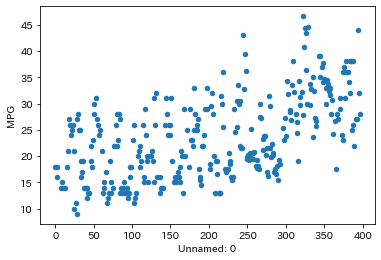

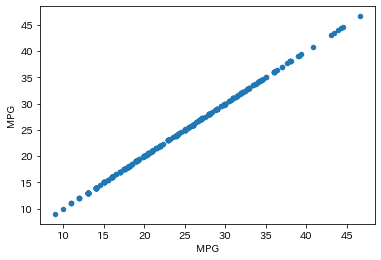

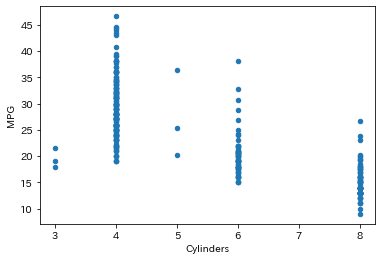

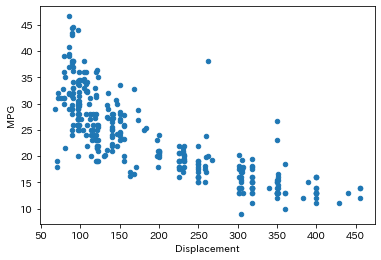

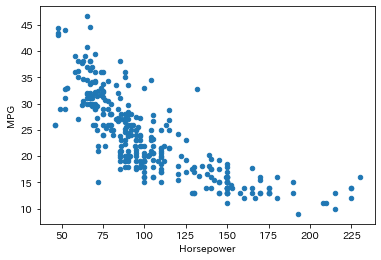

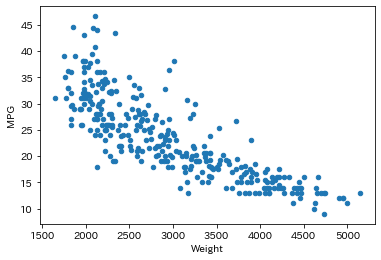

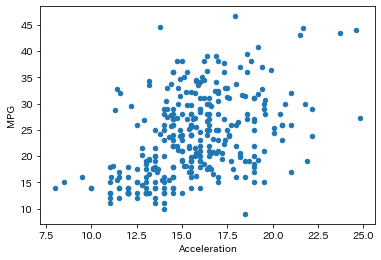

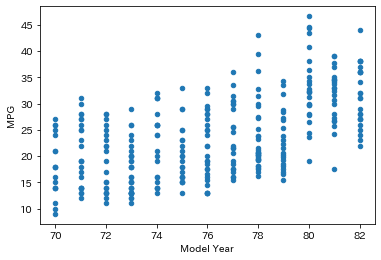

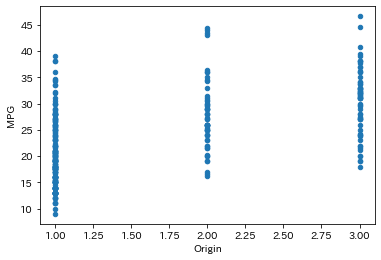

In [11]:
#外れ値の確認
colname = train_val2.columns
for name in colname:
  train_val2.plot(kind = 'scatter', x = name,y= 'MPG')

In [12]:
#外れ値が存在するインデックスを確認する
#displacementの外れ値
out_line1 = train_val2[(train_val2['MPG'] > 35) & (train_val2['Displacement'] > 250)].index
out_line2 = train_val2[(train_val2['MPG'] > 20) & (train_val2['Displacement'] > 325)].index
#Horsepowerの外れ値
out_line3 = train_val2[(train_val2['MPG'] > 30) & (train_val2['Horsepower'] > 125)].index
out_line4 = train_val2[(train_val2['MPG'] < 20) & (train_val2['Horsepower'] < 75)].index
#Weightの外れ値
out_line5 = train_val2[(train_val2['MPG'] < 20) & (train_val2['Weight'] < 2200)].index
out_line6 = train_val2[(train_val2['MPG'] > 35) & (train_val2['Weight'] > 2900)].index
#Accelerationの外れ値
out_line7 = train_val2[(train_val2['MPG'] > 43) & (train_val2['Acceleration'] < 20)].index
out_line8 = train_val2[(train_val2['MPG'] < 30) & (train_val2['Acceleration'] > 23)].index
out_line9 = train_val2[(train_val2['MPG'] < 10) & (train_val2['Acceleration'] > 17.5)].index

print(out_line1, out_line2, out_line3, out_line4,out_line5,out_line6,out_line7, out_line8, out_line9)


Int64Index([387], dtype='int64') Int64Index([298, 364], dtype='int64') Int64Index([333], dtype='int64') Int64Index([155], dtype='int64') Int64Index([111], dtype='int64') Int64Index([327, 387], dtype='int64') Int64Index([322, 329], dtype='int64') Int64Index([299], dtype='int64') Int64Index([28], dtype='int64')


## 外れ値を削除する

In [13]:
train_val3 = train_val2.drop([387,298,364,333,155,111,327,322,329,299,28],axis = 0)

#絞り込んだ列以外を取り除く
col = ['MPG','Displacement','Horsepower','Weight','Acceleration']
train_val4 = train_val3[col]
train_val4.head(5)

,MPG,Displacement,Horsepower,Weight,Acceleration
64,15.0,318.0,150.0,4135,13.5
55,27.0,97.0,60.0,1834,19.0
317,34.3,97.0,78.0,2188,15.8
102,26.0,97.0,46.0,1950,21.0
358,31.6,120.0,74.0,2635,18.3


## 相関関係による特徴量の絞り込み


In [14]:
#列同士の相関係数を調べる
train_val4.corr()


,MPG,Displacement,Horsepower,Weight,Acceleration
MPG,1.000000,-0.828741,-0.803977,-0.847011,0.499976
Displacement,-0.828741,1.000000,0.904838,0.936196,-0.584401
Horsepower,-0.803977,0.904838,1.000000,0.867931,-0.709139
Weight,-0.847011,0.936196,0.867931,1.000000,-0.465092
Acceleration,0.499976,-0.584401,-0.709139,-0.465092,1.000000


In [15]:
#各列とtarget列との相関係数を見る
train_cor = train_val4.corr()['MPG']
train_cor

MPG             1.000000
Displacement   -0.828741
Horsepower     -0.803977
Weight         -0.847011
Acceleration    0.499976
Name: MPG, dtype: float64

In [16]:
#abs関数で絶対値に変換
abs_cor = train_cor.map(abs)
#降順で並び替える
abs_cor.sort_values(ascending = False)

MPG             1.000000
Weight          0.847011
Displacement    0.828741
Horsepower      0.803977
Acceleration    0.499976
Name: MPG, dtype: float64

In [17]:
#訓練データと検証データの分割
col = ['Displacement','Horsepower','Weight']
x = train_val4[col]
t = train_val4[['MPG']]
x_train, x_val, y_train, y_val = train_test_split(x, t, test_size = 0.2, random_state = 0)

##データの標準化

In [18]:
from sklearn.preprocessing import StandardScaler

sc_model_x = StandardScaler()
sc_model_x.fit(x_train)

#各列のデータを標準化してsc_xに代入
sc_x = sc_model_x.transform(x_train)
sc_x

array([[ 6.67003684e-01,  4.55839730e-01,  5.47587465e-01],
       [ 8.99666166e-02, -5.22960760e-01,  4.19270609e-02],
       [ 8.99666166e-02, -2.43303477e-01,  2.40579362e-01],
       [ 1.59225277e+00,  1.35074304e+00,  1.51676991e+00],
       [-1.05415860e+00, -9.42446685e-01, -1.06571001e+00],
       [-7.05946580e-01, -1.87372021e-01, -5.61253564e-01],
       [ 4.08331895e-01, -1.03474836e-01, -1.22508395e-02],
       [-5.06968280e-01, -3.27200662e-01, -4.61325436e-01],
       [ 1.10475594e+00,  7.07531285e-01,  2.57434709e-01],
       [-1.11385209e+00, -9.42446685e-01, -1.06089420e+00],
       [-9.34771623e-01, -1.02634387e+00, -1.16804605e+00],
       [ 1.58230386e+00,  1.71429750e+00,  1.50954619e+00],
       [ 3.98382980e-01,  3.16011089e-01,  3.48935163e-01],
       [-1.05415860e+00, -1.44582979e+00, -1.10784838e+00],
       [ 1.10475594e+00,  9.31257111e-01,  1.30848598e+00],
       [ 1.59225277e+00,  9.59222840e-01,  1.20374204e+00],
       [ 3.38689490e-01, -2.43303477e-01

In [19]:
#平均値0を確認する
tmp_df = pd.DataFrame(sc_x, columns = x_train.columns)
#平均値の計算
tmp_df.mean()

Displacement    6.797284e-18
Horsepower      1.151007e-16
Weight          1.087565e-16
dtype: float64

In [20]:
#標準偏差1を確認する
tmp_df.std()

Displacement    1.002047
Horsepower      1.002047
Weight          1.002047
dtype: float64

In [21]:
#正解データを標準化する
sc_model_y = StandardScaler()
sc_model_y.fit(y_train)
sc_y = sc_model_y.transform(y_train)

In [22]:
#標準化したデータで学習させる
model = LinearRegression()
model.fit(sc_x, sc_y)

#scoreメソッドで決定係数を求める
model.score(x_val, y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


-38307.575114838044

In [24]:
#検証データを標準化する
sc_x_val = sc_model_x.transform(x_val)
sc_y_val = sc_model_y.transform(y_val)
#標準化した検証データで決定係数を計算
model.score(sc_x_val, sc_y_val)

0.7462588800368013

## 検証データの標準化（チューニングの実施）

In [25]:
# learn関数の定義
def learn(x,t):
  x_train,x_val,y_train,y_val = train_test_split(x,t,test_size = 0.2, random_state = 0)

  # 訓練データを標準化
  sc_model_x = StandardScaler()
  sc_model_y = StandardScaler()
  sc_model_x.fit(x_train)
  sc_x_train = sc_model_x.transform(x_train)
  sc_model_y.fit(y_train)
  sc_y_train = sc_model_y.transform(y_train)
  # 学習
  model = LinearRegression()
  model.fit(sc_x_train, sc_y_train)
  # 検証データを標準化
  sc_x_val = sc_model_x.transform(x_val)
  sc_y_val = sc_model_y.transform(y_val)
  # 訓練データと検証データの決定係数計算
  train_score = model.score(sc_x_train,sc_y_train)
  val_score = model.score(sc_x_val,sc_y_val)

  return train_score,val_score

In [26]:
# learn関数を実行
x = train_val4.loc[ :,['Displacement','Horsepower','Weight']]
t = train_val4[['MPG']]
s1,s2 = learn(x,t)
print(s1,s2)

0.732959426109451 0.7462588800368013


In [27]:
#データフレームのWeight,Displacement,Horsepower,のデータを2乗する
x['Weight2'] = x['Weight'] ** 2
s1,s2 = learn(x,t)
print(s1,s2)

x['Displacement2'] = x['Displacement'] ** 2
s1,s2 = learn(x,t)
print(s1,s2)

x['Horsepower2'] = x['Horsepower'] ** 2
s1,s2 = learn(x,t)
print(s1,s2)


0.7606877021868641 0.7926560321715101
0.7749345035434654 0.7996579377868945
0.7816400933705909 0.8177058475152126


In [29]:
#交互作用特徴量を追加する
x['Weight * Displacement'] = x['Weight'] * x['Displacement']
#特徴量を追加したので再学習を行う
s1, s2 = learn(x,t)
print(s1,s2)

0.7860596742206246 0.813837210058203


# 検証データでの決定係数が0.81を超えたので終了